In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from utilities import Old_CNN_bw, Old_CNN_color
from tqdm.notebook import tqdm

In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [3]:
#"../../../shenhao/sat_image_nhts/code/data_process/"

import pickle
with open('../census_id_to_index.pickle', 'rb') as handle:
    census_id_to_index = pickle.load(handle)

In [4]:
def training(x_id_train, y_train, x_id_test, y_test, optimizer, criterion, n_epochs = 100, batch_size = 200):
#More memory efficient?

    #training
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    validate_losses = []
    validate_accuracies = []

    validate_losses_running = []
    validate_accurate_running = []


    test_indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in x_id_test]
    x_test_images = image_array[test_indices,:,:,:]
    x_test_images_norm_torch = torch.as_tensor(x_test_images).float()/255.0
    
    
    y_train_torch = torch.as_tensor(y_train[:,0])
    y_test_torch = torch.as_tensor(y_test[:,0])
    print(y_train_torch.size())
    print(y_test_torch.size())
    
    print("Training started: ")

    for n_epoch in range(n_epoches):
        # create permutation for batch training
        # To-Do: add permutation for SGD...But it is slow.
        #permutation = torch.randperm(x_train_images_norm_torch.size()[0])
        print("epoch: ", n_epoch)
        for i in tqdm(range(0, x_id_train.shape[0], batch_size)):
            # clear gradients first (for each iteration!)!
            optim.zero_grad()
            # forward pass

            #Get the indices in the image array of this batch
            ids = x_id_train[i:i+batch_size]
            indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

            #convert to torch and normalize
            to_torch = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0

            batch_x, batch_y = to_torch.to(device), y_train_torch[i:i+batch_size].to(device)

            batch_y_pred_train = cnn_net(batch_x)
            # loss 
            loss = criterion(batch_y_pred_train.squeeze(), batch_y)
            # compute gradients
            loss.backward()
            # one step optim
            optim.step()

        # eval training accuracy
        with torch.no_grad():
            # evaluate training loss/accuracy in batches


            train_losses_running = []
            train_accurate_running = []

            validate_losses_running = []
            validate_accurate_running = []


            for i in range(0, x_id_train.shape[0], batch_size):

                # load batch data
                ids = x_id_train[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

                batch_image_train_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_train = y_train_torch[i:i+batch_size].to(device)
                y_batch_probs_train = cnn_net(batch_image_train_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_train.size()[0]
                loss_train = criterion(y_batch_probs_train.squeeze(), batch_y_train)
                train_losses_running.append(loss_train.item() * current_batch_size)

                # evaluate accuracy on current batch
                _, batch_predict_train = torch.max(y_batch_probs_train, axis = 1)
                accurate_pred_train = (batch_predict_train == batch_y_train).sum().item()
                train_accurate_running.append(accurate_pred_train)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            train_losses.append(sum(train_losses_running) / x_id_train.shape[0]) # average loss per epoch
            train_accuracies.append(sum(train_accurate_running) / x_id_train.shape[0]) # average accuracy per epoch


            # evaluate validation accuracy/loss in batches
            for i in range(0, x_id_test.shape[0], batch_size):

                # load batch data

                ids = x_id_test[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]


                batch_image_val_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_val = y_test_torch[i:i+batch_size].to(device)
                y_batch_probs_val = cnn_net(batch_image_val_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_val.size()[0]
                loss_validate = criterion(y_batch_probs_val.squeeze(), batch_y_val)
                validate_losses_running.append(loss_validate.item() * current_batch_size)

                # evaluate accuracy on current batch
                _, batch_predict_val = torch.max(y_batch_probs_val, axis = 1)
                accurate_pred_val = (batch_predict_val == batch_y_val).sum().item()
                validate_accurate_running.append(accurate_pred_val)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            validate_losses.append(sum(validate_losses_running) / x_id_test.shape[0]) # average loss per epoch
            validate_accuracies.append(sum(validate_accurate_running) / x_id_test.shape[0]) # average accuracy per epoch


            # print performance updates
            if n_epoch % 5 == 0:
                print("Printing accuracies")
                #_, preds = torch.max(cnn_net(x_test_images_norm_torch.to(device)), axis=1)
                #unique = preds.unique(sorted=True)
                print('Epoch {}: train loss: {}'.format(n_epoch, train_losses[-1]))
                print('Epoch {}: train accuracy: {}'.format(n_epoch, train_accuracies[-1]))
                #print('Epoch {}: prediction counts: {}'.format(n_epoch, [(i.item(), (preds==i).sum().item()) for i in unique] ))
                print('Epoch {}: validate loss: {}'.format(n_epoch, validate_losses[-1]))
                print('Epoch {}: validate accuracy: {}'.format(n_epoch, validate_accuracies[-1]))

    return train_losses, validate_losses, train_accuracies, validate_accuracies
   



In [5]:
train_unique = pd.read_csv("../train_unique.csv")
test_unique = pd.read_csv("../test_unique.csv")

In [6]:
train_unique.head()

,Unnamed: 0,CENSUS_ID,HHCT,HHCNTYFP,WEBUSE17_HIGH,WALK2SAVE_AGREE,WALK_HIGH,TAXI_HIGH,TAB_HIGH,SPHONE_HIGH,...,HBHUR,HBHTNRNT,GASPRICE,EDUC,ENDTIME,DRVRCNT,DRIVER,CENSUS_R,CENSUS_D,CDIVMSAR
0,40900,37183053422,53422,183,1,0,1,0,1,1,...,C,5,234.0,5,509,2,1,3,5,52
1,351773,36005019300,19300,5,1,1,1,0,0,0,...,U,90,237.2,3,1200,0,0,1,2,21
2,347555,17141961300,961300,141,1,0,1,0,0,0,...,R,5,217.4,5,1200,2,1,2,3,34
3,145315,40109107211,107211,109,1,0,0,0,0,1,...,C,30,224.2,3,1700,2,1,3,7,72
4,248640,37067002702,2702,67,1,0,0,0,0,1,...,C,80,240.8,3,900,1,1,3,5,53


In [7]:
test_unique.head()

,Unnamed: 0,CENSUS_ID,HHCT,HHCNTYFP,WEBUSE17_HIGH,WALK2SAVE_AGREE,WALK_HIGH,TAXI_HIGH,TAB_HIGH,SPHONE_HIGH,...,HBHUR,HBHTNRNT,GASPRICE,EDUC,ENDTIME,DRVRCNT,DRIVER,CENSUS_R,CENSUS_D,CDIVMSAR
0,5281,36055012500,12500,55,1,1,0,0,0,1,...,S,5,244.7,5,755,1,1,1,2,22
1,615389,50007000100,100,7,1,0,1,0,0,1,...,S,30,248.0,5,650,1,1,1,1,13
2,291709,34025810502,810502,25,1,0,0,0,0,1,...,T,0,232.6,5,610,2,1,1,2,21
3,125237,37183053424,53424,183,1,1,0,0,0,1,...,C,20,222.7,4,810,1,1,3,5,52
4,252390,35043010722,10722,43,1,0,0,0,1,1,...,S,5,218.0,5,1751,2,1,4,8,83


In [8]:
x_id_train = train_unique["CENSUS_ID"].values.reshape(-1,1)
print(x_id_train.shape)
print(x_id_train)
x_id_test = test_unique["CENSUS_ID"].values.reshape(-1,1)
print(x_id_test.shape)
print(x_id_test)
y_train = train_unique["HHVEHCNT"].values.reshape(-1,1)
print(y_train.shape)
y_test = test_unique["HHVEHCNT"].values.reshape(-1,1)
print(y_test.shape)

(27234, 1)
[[37183053422]
 [36005019300]
 [17141961300]
 ...
 [ 6053012800]
 [13139000303]
 [36033951200]]
(5447, 1)
[[36055012500]
 [50007000100]
 [34025810502]
 ...
 [ 4013093104]
 [ 6037460600]
 [ 6073015405]]
(27234, 1)
(5447, 1)


In [9]:
print(np.unique(y_train))
classes = len(np.unique(y_train,return_counts = True)[0])
print(classes)

[0 1 2 3]
4


In [10]:
print(np.unique(y_test, return_counts=True)[1]/sum(np.unique(y_test, return_counts=True)[1]))

[0.0519552  0.30659078 0.39783367 0.24362034]


# Old CNN bw

In [11]:
image_array = np.load("image_array_bw.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.0519552 , 0.30659078, 0.39783367, 0.24362034])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 4, 224, 224)

In [16]:
cnn_net = Old_CNN_bw(K).float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [17]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.3106468049774456
Epoch 0: train accuracy: 0.3809209076889183
Epoch 0: validate loss: 1.3047414302650846
Epoch 0: validate accuracy: 0.3978336699100422
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.3045482456469628
Epoch 5: train accuracy: 0.3809209076889183
Epoch 5: validate loss: 1.2944731743199598
Epoch 5: validate accuracy: 0.3978336699100422
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.3045637255820828
Epoch 10: train accuracy: 0.3809209076889183
Epoch 10: validate loss: 1.2944544908517608
Epoch 10: validate accuracy: 0.3978336699100422
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.3045693393967668
Epoch 15: train accuracy: 0.3809209076889183
Epoch 15: validate loss: 1.2944482566239266
Epoch 15: validate accuracy: 0.3978336699100422
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.3045716259967495
Epoch 20: train accuracy: 0.3809209076889183
Epoch 20: validate loss: 1.2944455079601647
Epoch 20: validate accuracy: 0.3978336699100422
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.3045727371547928
Epoch 25: train accuracy: 0.3809209076889183
Epoch 25: validate loss: 1.2944442576085708
Epoch 25: validate accuracy: 0.3978336699100422
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.304573454625405
Epoch 30: train accuracy: 0.3809209076889183
Epoch 30: validate loss: 1.294443823994902
Epoch 30: validate accuracy: 0.3978336699100422
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.304573543369223
Epoch 35: train accuracy: 0.3809209076889183
Epoch 35: validate loss: 1.2944433528041541
Epoch 35: validate accuracy: 0.3978336699100422
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.3045736594531752
Epoch 40: train accuracy: 0.3809209076889183
Epoch 40: validate loss: 1.2944431993443528
Epoch 40: validate accuracy: 0.3978336699100422
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.3045737796517172
Epoch 45: train accuracy: 0.3809209076889183
Epoch 45: validate loss: 1.2944432024301817
Epoch 45: validate accuracy: 0.3978336699100422
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.3045737374640425
Epoch 50: train accuracy: 0.3809209076889183
Epoch 50: validate loss: 1.2944431115404846
Epoch 50: validate accuracy: 0.3978336699100422
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.3045737144048322
Epoch 55: train accuracy: 0.3809209076889183
Epoch 55: validate loss: 1.2944430237366165
Epoch 55: validate accuracy: 0.3978336699100422
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.304573752924394
Epoch 60: train accuracy: 0.3809209076889183
Epoch 60: validate loss: 1.2944430631301764
Epoch 60: validate accuracy: 0.3978336699100422
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.3045737371663912
Epoch 65: train accuracy: 0.3809209076889183
Epoch 65: validate loss: 1.2944430456219276
Epoch 65: validate accuracy: 0.3978336699100422
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.3045737643051736
Epoch 70: train accuracy: 0.3809209076889183
Epoch 70: validate loss: 1.294443071884301
Epoch 70: validate accuracy: 0.3978336699100422
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.3045737380418359
Epoch 75: train accuracy: 0.3809209076889183
Epoch 75: validate loss: 1.2944430237366165
Epoch 75: validate accuracy: 0.3978336699100422
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.3045737818140652
Epoch 80: train accuracy: 0.3809209076889183
Epoch 80: validate loss: 1.2944430806384253
Epoch 80: validate accuracy: 0.3978336699100422
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.3045737756859532
Epoch 85: train accuracy: 0.3809209076889183
Epoch 85: validate loss: 1.2944430587531144
Epoch 85: validate accuracy: 0.3978336699100422
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.3045737756859532
Epoch 90: train accuracy: 0.3809209076889183
Epoch 90: validate loss: 1.2944430587531144
Epoch 90: validate accuracy: 0.3978336699100422
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.3045737756859532
Epoch 95: train accuracy: 0.3809209076889183
Epoch 95: validate loss: 1.2944430587531144
Epoch 95: validate accuracy: 0.3978336699100422
epoch:  96



epoch:  97



epoch:  98



epoch:  99


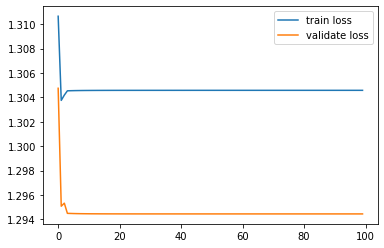

In [18]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

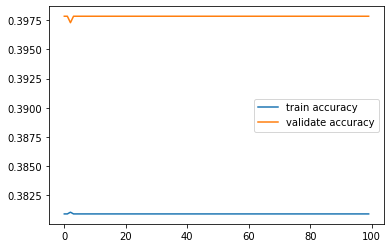

In [19]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Old CNN Color

In [20]:
image_array = np.load("image_array_color.npy", mmap_mode = 'r+')

In [21]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.0519552 , 0.30659078, 0.39783367, 0.24362034])

In [22]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [23]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [24]:
image_array.shape

(32681, 3, 224, 224)

In [25]:
cnn_net = Old_CNN_color(K).float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [26]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.3449049191808633
Epoch 0: train accuracy: 0.3809209076889183
Epoch 0: validate loss: 1.3353394709181432
Epoch 0: validate accuracy: 0.3978336699100422
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.3446887547446127
Epoch 5: train accuracy: 0.3809209076889183
Epoch 5: validate loss: 1.3339818647985877
Epoch 5: validate accuracy: 0.3978336699100422
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.3447077878029097
Epoch 10: train accuracy: 0.3809209076889183
Epoch 10: validate loss: 1.333939117774277
Epoch 10: validate accuracy: 0.3978336699100422
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.3447149253376536
Epoch 15: train accuracy: 0.3809209076889183
Epoch 15: validate loss: 1.3339253294592672
Epoch 15: validate accuracy: 0.3978336699100422
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.3447180676321946
Epoch 20: train accuracy: 0.3809209076889183
Epoch 20: validate loss: 1.3339197244778978
Epoch 20: validate accuracy: 0.3978336699100422
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.3447194888026754
Epoch 25: train accuracy: 0.3809209076889183
Epoch 25: validate loss: 1.333917219244451
Epoch 25: validate accuracy: 0.3978336699100422
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.3447201535189968
Epoch 30: train accuracy: 0.3809209076889183
Epoch 30: validate loss: 1.3339159771873905
Epoch 30: validate accuracy: 0.3978336699100422
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.3447201599972867
Epoch 35: train accuracy: 0.3809209076889183
Epoch 35: validate loss: 1.3339151288033058
Epoch 35: validate accuracy: 0.3978336699100422
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.3447206806329375
Epoch 40: train accuracy: 0.3809209076889183
Epoch 40: validate loss: 1.3339151200491812
Epoch 40: validate accuracy: 0.3978336699100422
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.3447204987680788
Epoch 45: train accuracy: 0.3809209076889183
Epoch 45: validate loss: 1.3339146967653792
Epoch 45: validate accuracy: 0.3978336699100422
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.3447206296207814
Epoch 50: train accuracy: 0.3809209076889183
Epoch 50: validate loss: 1.333914717359457
Epoch 50: validate accuracy: 0.3978336699100422
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.3447205855509008
Epoch 55: train accuracy: 0.3809209076889183
Epoch 55: validate loss: 1.3339146329040414
Epoch 55: validate accuracy: 0.3978336699100422
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.3447205455605922
Epoch 60: train accuracy: 0.3809209076889183
Epoch 60: validate loss: 1.3339145662194987
Epoch 60: validate accuracy: 0.3978336699100422
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.3447205588235775
Epoch 65: train accuracy: 0.3809209076889183
Epoch 65: validate loss: 1.333914542539592
Epoch 65: validate accuracy: 0.3978336699100422
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.3447205432144005
Epoch 70: train accuracy: 0.3809209076889183
Epoch 70: validate loss: 1.3339145119001565
Epoch 70: validate accuracy: 0.3978336699100422
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.3447205687511192
Epoch 75: train accuracy: 0.3809209076889183
Epoch 75: validate loss: 1.333914540219749
Epoch 75: validate accuracy: 0.3978336699100422
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.34472056700023
Epoch 80: train accuracy: 0.3809209076889183
Epoch 80: validate loss: 1.333914540219749
Epoch 80: validate accuracy: 0.3978336699100422
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.3447205197087133
Epoch 85: train accuracy: 0.3809209076889183
Epoch 85: validate loss: 1.3339144900148454
Epoch 85: validate accuracy: 0.3978336699100422
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.344720563778594
Epoch 90: train accuracy: 0.3809209076889183
Epoch 90: validate loss: 1.333914540219749
Epoch 90: validate accuracy: 0.3978336699100422
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.344720563778594
Epoch 95: train accuracy: 0.3809209076889183
Epoch 95: validate loss: 1.333914540219749
Epoch 95: validate accuracy: 0.3978336699100422
epoch:  96



epoch:  97



epoch:  98



epoch:  99


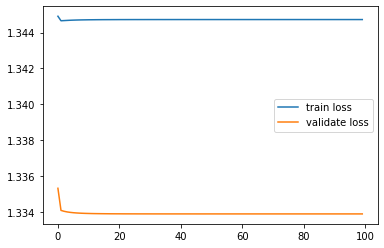

In [27]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

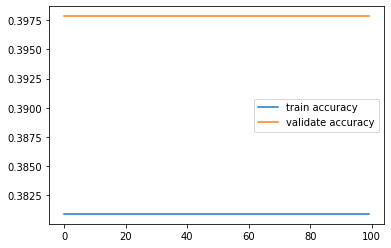

In [28]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Resnet18 Color

In [12]:
image_array = np.load("image_array_color.npy", mmap_mode = 'r+')

In [13]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.0519552 , 0.30659078, 0.39783367, 0.24362034])

In [14]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [15]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [16]:
image_array.shape

(32681, 3, 224, 224)

In [17]:
from torchvision import models

model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, classes)
print(list(model_ft.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [18]:
cnn_net = model_ft.float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [19]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.2598408874964988
Epoch 0: train accuracy: 0.38000293750458985
Epoch 0: validate loss: 1.2639305530085527
Epoch 0: validate accuracy: 0.39397833669910043
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.2317942421875958
Epoch 5: train accuracy: 0.3812880957626496
Epoch 5: validate loss: 1.2291801055024387
Epoch 5: validate accuracy: 0.39728290802276484
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.2299229202181563
Epoch 10: train accuracy: 0.3813615333773959
Epoch 10: validate loss: 1.2286984957487885
Epoch 10: validate accuracy: 0.3978336699100422
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.2290099938990673
Epoch 15: train accuracy: 0.3811412205331571
Epoch 15: validate loss: 1.2285143879765608
Epoch 15: validate accuracy: 0.39801725720580133
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.2281841431769225
Epoch 20: train accuracy: 0.3815818462216347
Epoch 20: validate loss: 1.2290156008191824
Epoch 20: validate accuracy: 0.39801725720580133
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.2279288489413942
Epoch 25: train accuracy: 0.3819123154879929
Epoch 25: validate loss: 1.2306198443056837
Epoch 25: validate accuracy: 0.3978336699100422
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.2255384705355052
Epoch 30: train accuracy: 0.38404200631563484
Epoch 30: validate loss: 1.2338330754888853
Epoch 30: validate accuracy: 0.3970993207270057
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.223516800456647
Epoch 35: train accuracy: 0.38503341411470954
Epoch 35: validate loss: 1.2311572378133007
Epoch 35: validate accuracy: 0.39728290802276484
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.2337114077058406
Epoch 40: train accuracy: 0.37985606227509733
Epoch 40: validate loss: 1.2341923871039469
Epoch 40: validate accuracy: 0.39746649531852396
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.2238134540124481
Epoch 45: train accuracy: 0.38551075861056033
Epoch 45: validate loss: 1.238913257537423
Epoch 45: validate accuracy: 0.39195887644574995
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.2212347456683512
Epoch 50: train accuracy: 0.39127561136814276
Epoch 50: validate loss: 1.2622520415875285
Epoch 50: validate accuracy: 0.3734165595740775
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.2661031357839505
Epoch 55: train accuracy: 0.38048028200044065
Epoch 55: validate loss: 1.4105259955684395
Epoch 55: validate accuracy: 0.3192583073251331
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.2241806441757563
Epoch 60: train accuracy: 0.5195711243298817
Epoch 60: validate loss: 1.9701201684413228
Epoch 60: validate accuracy: 0.3449605287314118
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.4814229604523508
Epoch 65: train accuracy: 0.5607329073951678
Epoch 65: validate loss: 2.798285880087931
Epoch 65: validate accuracy: 0.31338351386084085
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 0.3616533013486237
Epoch 70: train accuracy: 0.8742748035543806
Epoch 70: validate loss: 3.3750126165754537
Epoch 70: validate accuracy: 0.33008995777492195
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.02033133188609635
Epoch 75: train accuracy: 0.994639054123522
Epoch 75: validate loss: 4.231222073572676
Epoch 75: validate accuracy: 0.3310078942537176
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.0005226297037009207
Epoch 80: train accuracy: 0.9998531247705075
Epoch 80: validate loss: 4.842194504227488
Epoch 80: validate accuracy: 0.3275197356342941
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.00038794360542774783
Epoch 85: train accuracy: 0.9998531247705075
Epoch 85: validate loss: 5.04425288367232
Epoch 85: validate accuracy: 0.3267853864512576
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.0003387761389125614
Epoch 90: train accuracy: 0.9998531247705075
Epoch 90: validate loss: 5.210697477052513
Epoch 90: validate accuracy: 0.32733614833853497
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.000313047021591029
Epoch 95: train accuracy: 0.9998531247705075
Epoch 95: validate loss: 5.379236563599743
Epoch 95: validate accuracy: 0.32898843400036715
epoch:  96



epoch:  97



epoch:  98



epoch:  99


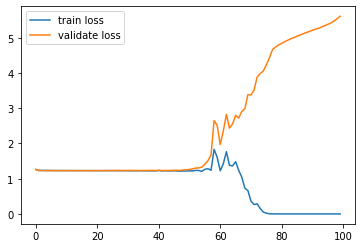

In [20]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

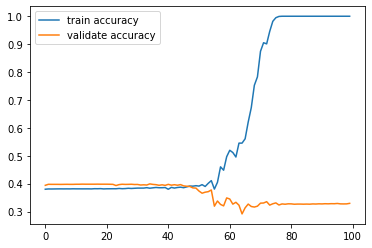

In [21]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Resnet18 bw


In [11]:
image_array = np.load("image_array_bw.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.0519552 , 0.30659078, 0.39783367, 0.24362034])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 4, 224, 224)

In [16]:
from torchvision import models
from torch.nn import Conv2d

model_ft = models.resnet18(pretrained=False)
for param in model_ft.parameters():
    param.requires_grad = True
model_ft.conv1 = Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, classes, bias = True)

In [17]:
cnn_net = model_ft.float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [18]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.2662503637475766
Epoch 0: train accuracy: 0.38084747007417197
Epoch 0: validate loss: 1.2637078673637787
Epoch 0: validate accuracy: 0.3978336699100422
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.2323083388627674
Epoch 5: train accuracy: 0.3809209076889183
Epoch 5: validate loss: 1.231318783558726
Epoch 5: validate accuracy: 0.3978336699100422
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.2382958324293283
Epoch 10: train accuracy: 0.3807373136520526
Epoch 10: validate loss: 1.2334920886417737
Epoch 10: validate accuracy: 0.39746649531852396
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.229274796399547
Epoch 15: train accuracy: 0.3809209076889183
Epoch 15: validate loss: 1.2277122803602785
Epoch 15: validate accuracy: 0.3978336699100422
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.2294889908315958
Epoch 20: train accuracy: 0.3809209076889183
Epoch 20: validate loss: 1.2293116894472143
Epoch 20: validate accuracy: 0.3978336699100422
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.2288927183878213
Epoch 25: train accuracy: 0.3809209076889183
Epoch 25: validate loss: 1.2275041156194177
Epoch 25: validate accuracy: 0.3978336699100422
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.2271375216829836
Epoch 30: train accuracy: 0.3818755966806198
Epoch 30: validate loss: 1.2276545635643237
Epoch 30: validate accuracy: 0.3976500826142831
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.223174941253494
Epoch 35: train accuracy: 0.3947271792612176
Epoch 35: validate loss: 1.230129322525075
Epoch 35: validate accuracy: 0.3937947494033413
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.2296217594971748
Epoch 40: train accuracy: 0.3857310714547991
Epoch 40: validate loss: 1.234488684255223
Epoch 40: validate accuracy: 0.39856801909307876
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.2362502608003705
Epoch 45: train accuracy: 0.44503194536241464
Epoch 45: validate loss: 1.481392864811545
Epoch 45: validate accuracy: 0.36240132182852947
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.2814700703198245
Epoch 50: train accuracy: 0.46978042153190863
Epoch 50: validate loss: 1.9301988007016897
Epoch 50: validate accuracy: 0.33982008445015605
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.3110539741283946
Epoch 55: train accuracy: 0.5179554968054637
Epoch 55: validate loss: 2.5117387510733535
Epoch 55: validate accuracy: 0.33449605287314116
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.4628764692711185
Epoch 60: train accuracy: 0.5299258280091063
Epoch 60: validate loss: 3.248369380752384
Epoch 60: validate accuracy: 0.33780062419680557
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.221714662275117
Epoch 65: train accuracy: 0.5876477931996769
Epoch 65: validate loss: 3.780879374182463
Epoch 65: validate accuracy: 0.33155865614099506
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.272235632128781
Epoch 70: train accuracy: 0.6132040831313799
Epoch 70: validate loss: 4.710013540508507
Epoch 70: validate accuracy: 0.324582338902148
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.1492947167417695
Epoch 75: train accuracy: 0.6589924359256811
Epoch 75: validate loss: 5.909234869298485
Epoch 75: validate accuracy: 0.3115476409032495
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.0687553526785367
Epoch 80: train accuracy: 0.6900932657707277
Epoch 80: validate loss: 6.813028609575384
Epoch 80: validate accuracy: 0.2939232605103727
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.245606005746616
Epoch 85: train accuracy: 0.6958581185283103
Epoch 85: validate loss: 7.605208577071502
Epoch 85: validate accuracy: 0.31228199008628604
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.8980680589893189
Epoch 90: train accuracy: 0.7497613277520746
Epoch 90: validate loss: 7.7003600583812695
Epoch 90: validate accuracy: 0.29704424453827794
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.8878657688789101
Epoch 95: train accuracy: 0.7610707204230006
Epoch 95: validate loss: 8.179880338829548
Epoch 95: validate accuracy: 0.3010831650449789
epoch:  96



epoch:  97



epoch:  98



epoch:  99


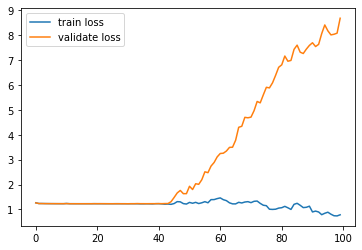

In [19]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

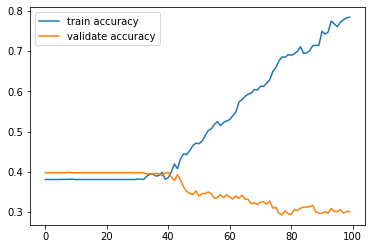

In [20]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()